In [9]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
import numpy as np

### **Task 1 (30 points)**

In [2]:
url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
titanic_df = pd.read_csv(url)

# first few rows
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# fill missing values
titanic_df['Age'] = titanic_df['Age'].fillna(titanic_df['Age'].mean()) # fill with mean
titanic_df['Embarked'] = titanic_df['Embarked'].fillna(titanic_df['Embarked'].mode()[0]) # fill with mode

titanic_cleaned_df = titanic_df.drop(columns=['Name', 'Ticket', 'Cabin'])

# turn to numerical
titanic_cleaned_df['Sex'] = titanic_cleaned_df['Sex'].map({'male': 0, 'female': 1})
titanic_cleaned_df['Embarked'] = titanic_cleaned_df['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

X = titanic_cleaned_df.drop(columns=['Survived'])
y = titanic_cleaned_df['Survived']

# https://www.geeksforgeeks.org/building-and-implementing-decision-tree-classifiers-with-scikit-learn-a-comprehensive-guide/
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# show first few rows of cleaned data
titanic_cleaned_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,0,22.0,1,0,7.2500,2
1,2,1,1,1,38.0,1,0,71.2833,0
2,3,1,3,1,26.0,0,0,7.9250,2
3,4,1,1,1,35.0,1,0,53.1000,2
4,5,0,3,0,35.0,0,0,8.0500,2


In [6]:
# fit dt classifier
dt_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_clf.fit(X_train, y_train)

# eval the model
y_pred = dt_clf.predict(X_test)
print(classification_report(y_test, y_pred))
print("accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       105
           1       0.80      0.69      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179

accuracy: 0.7988826815642458


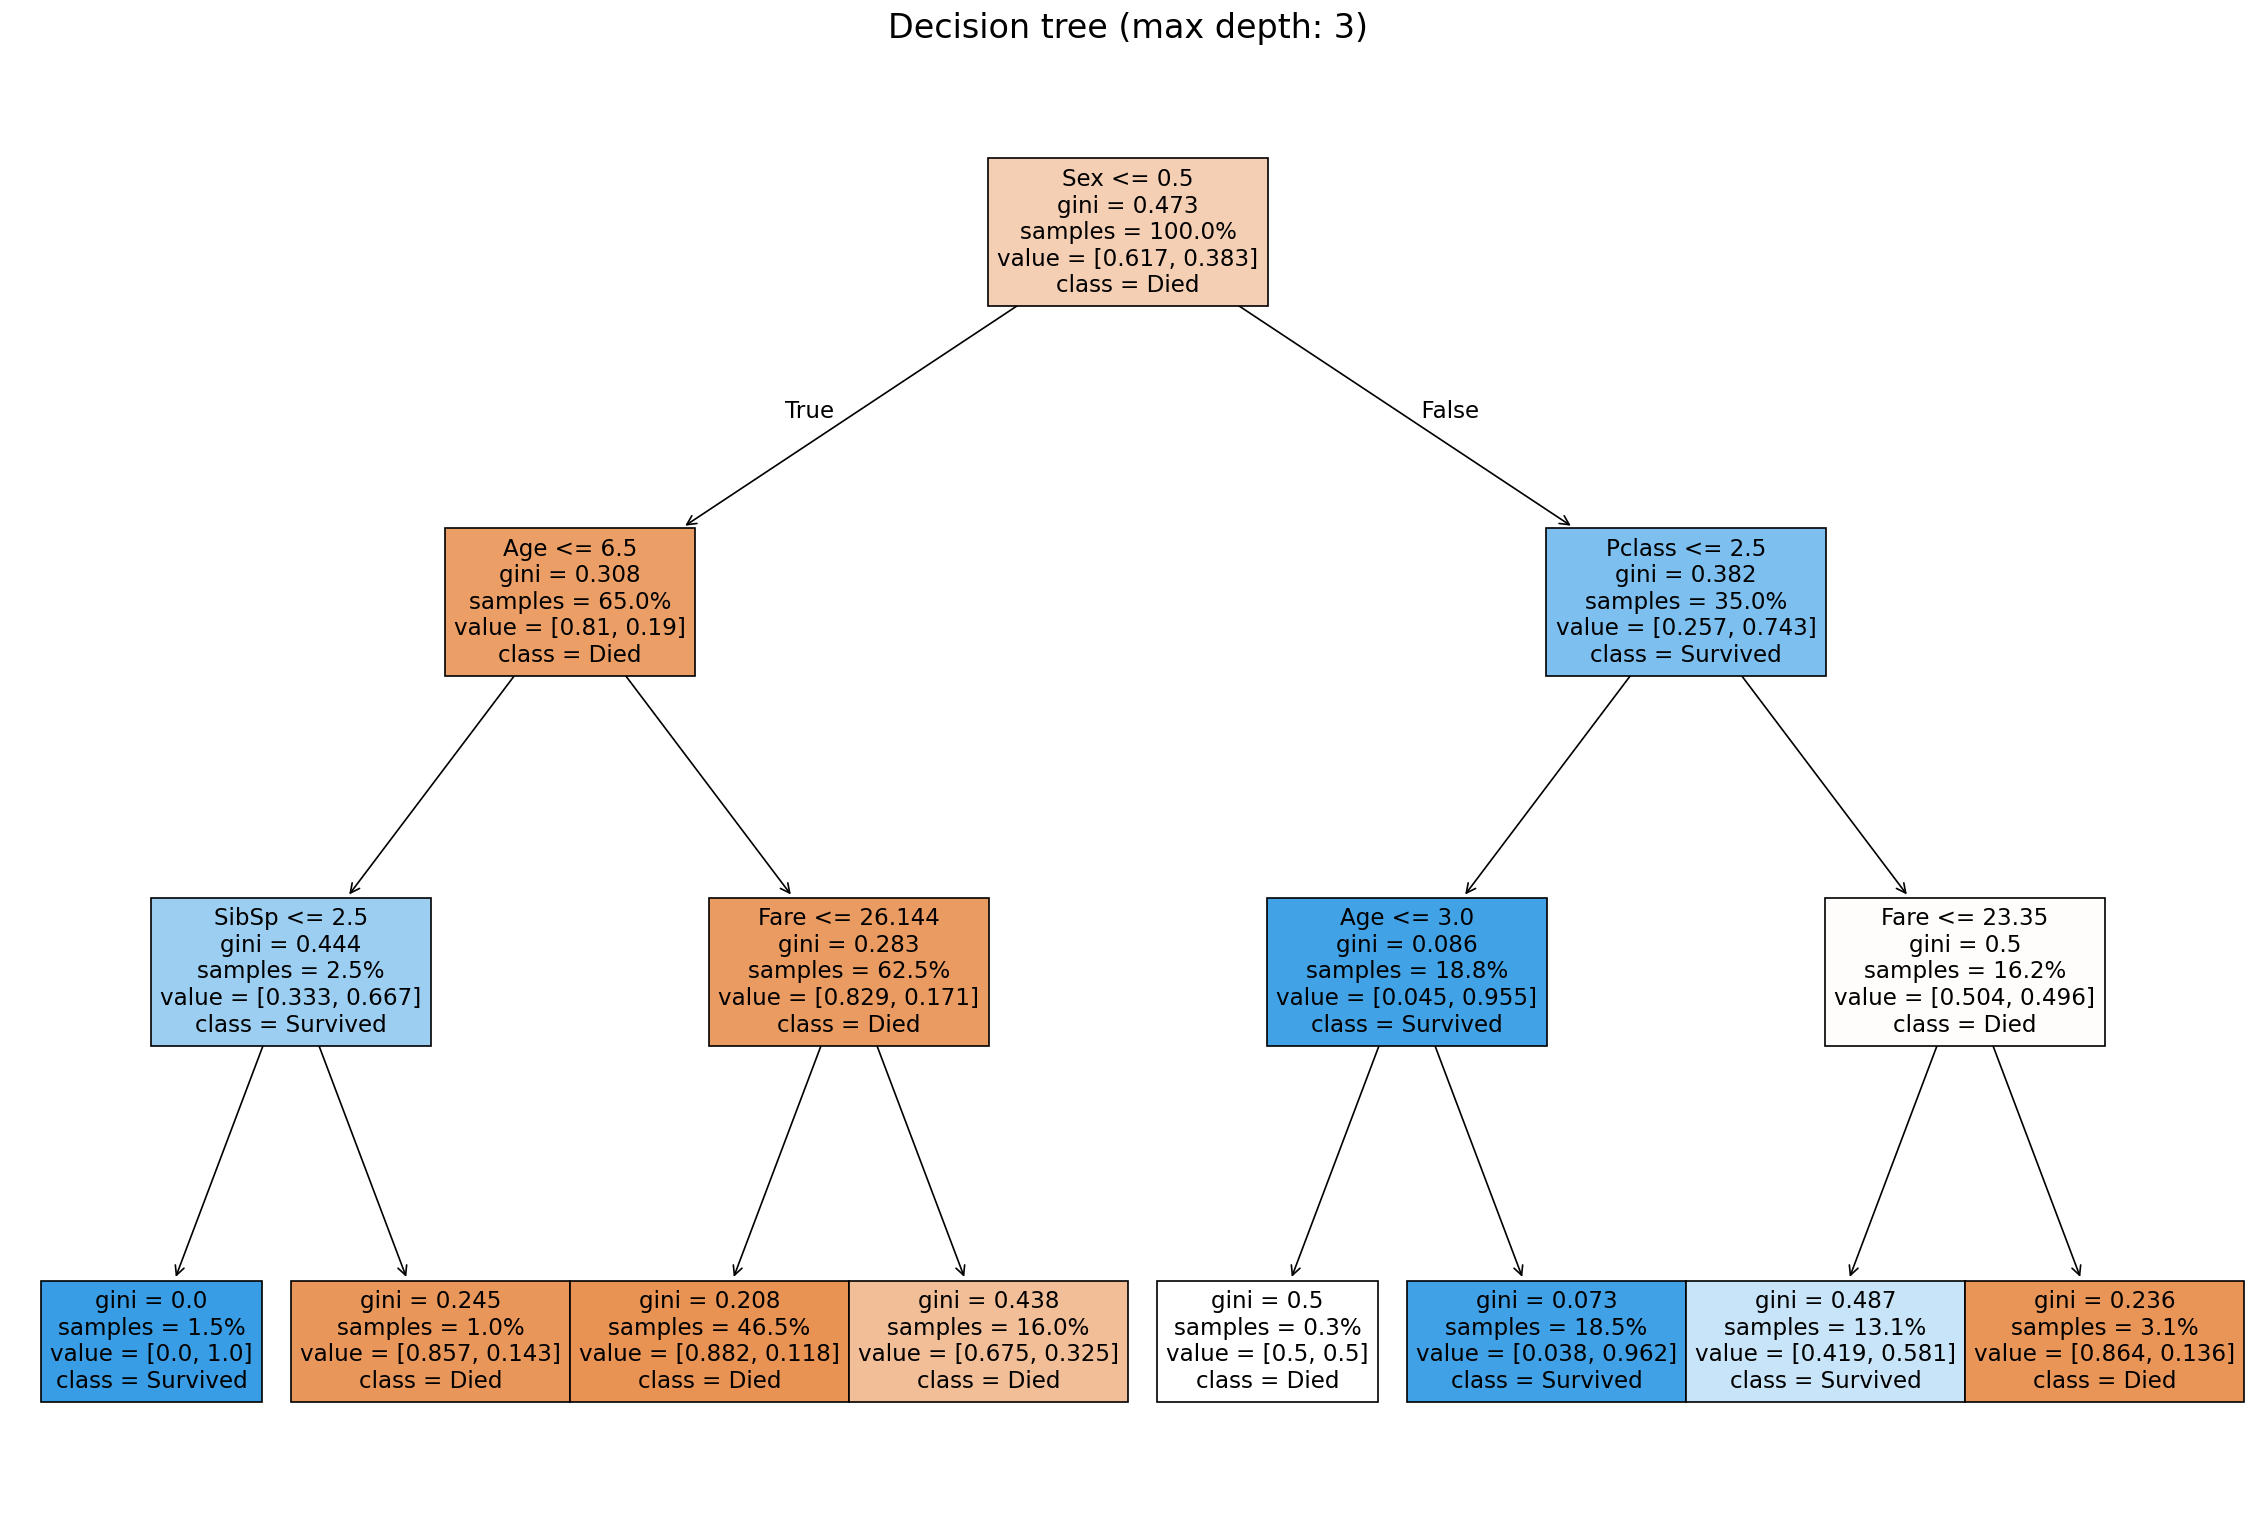

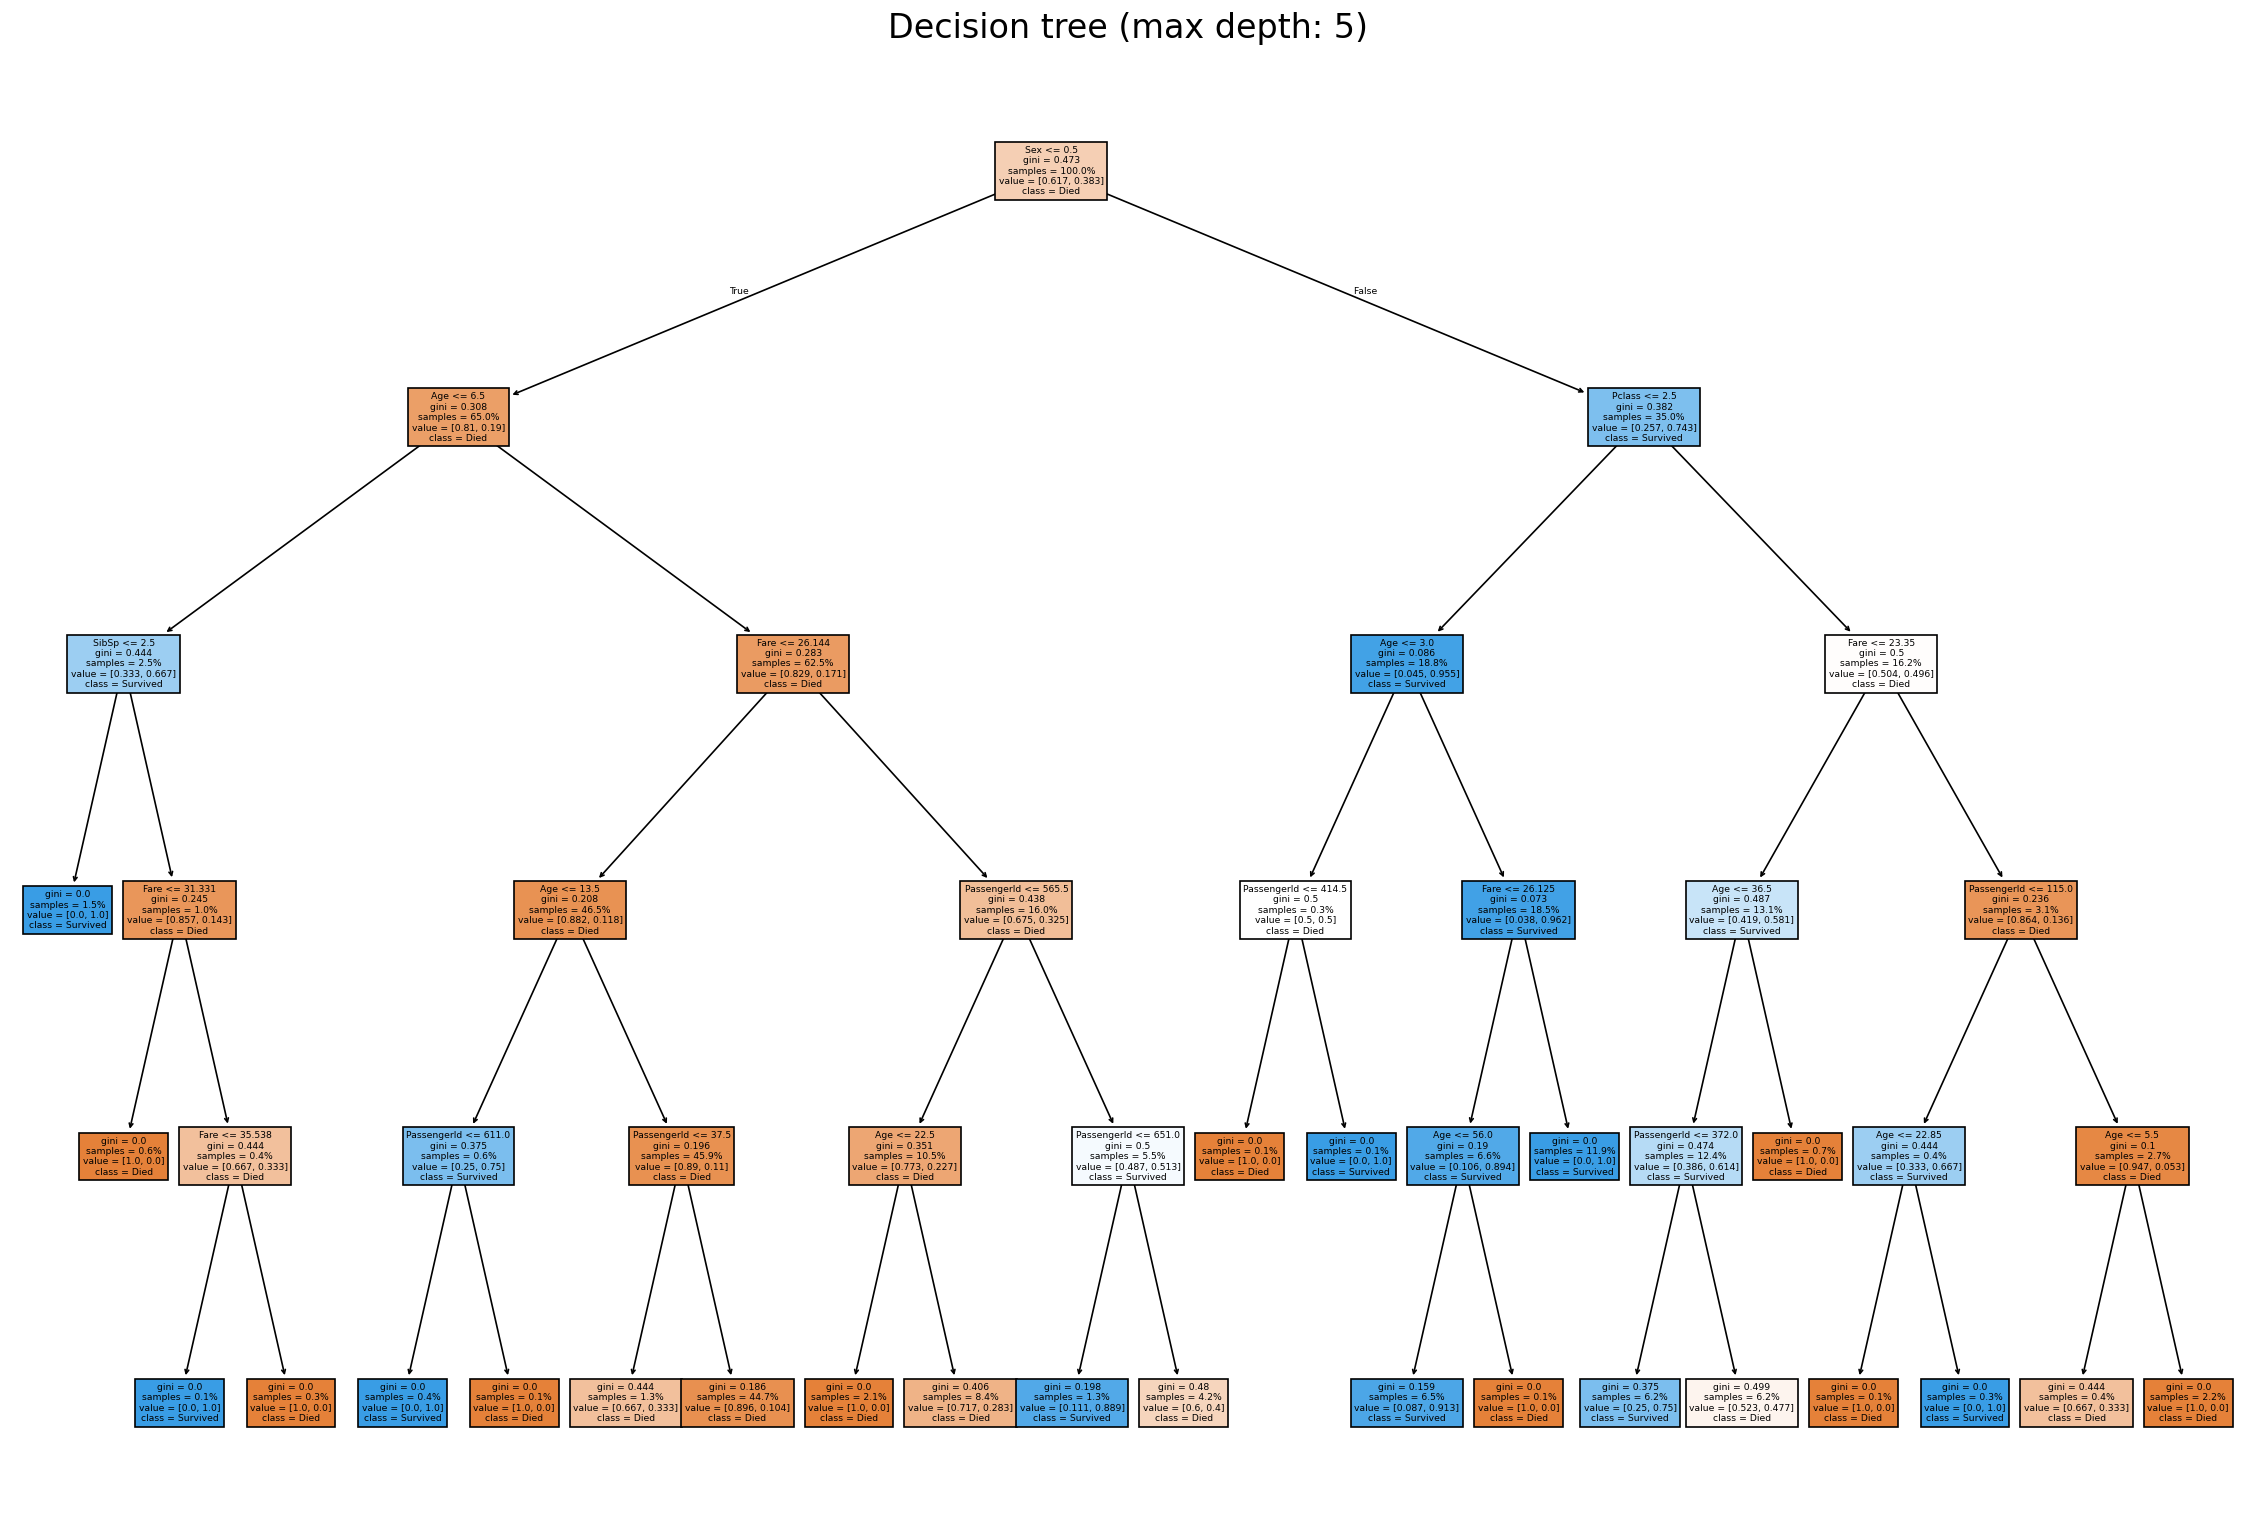

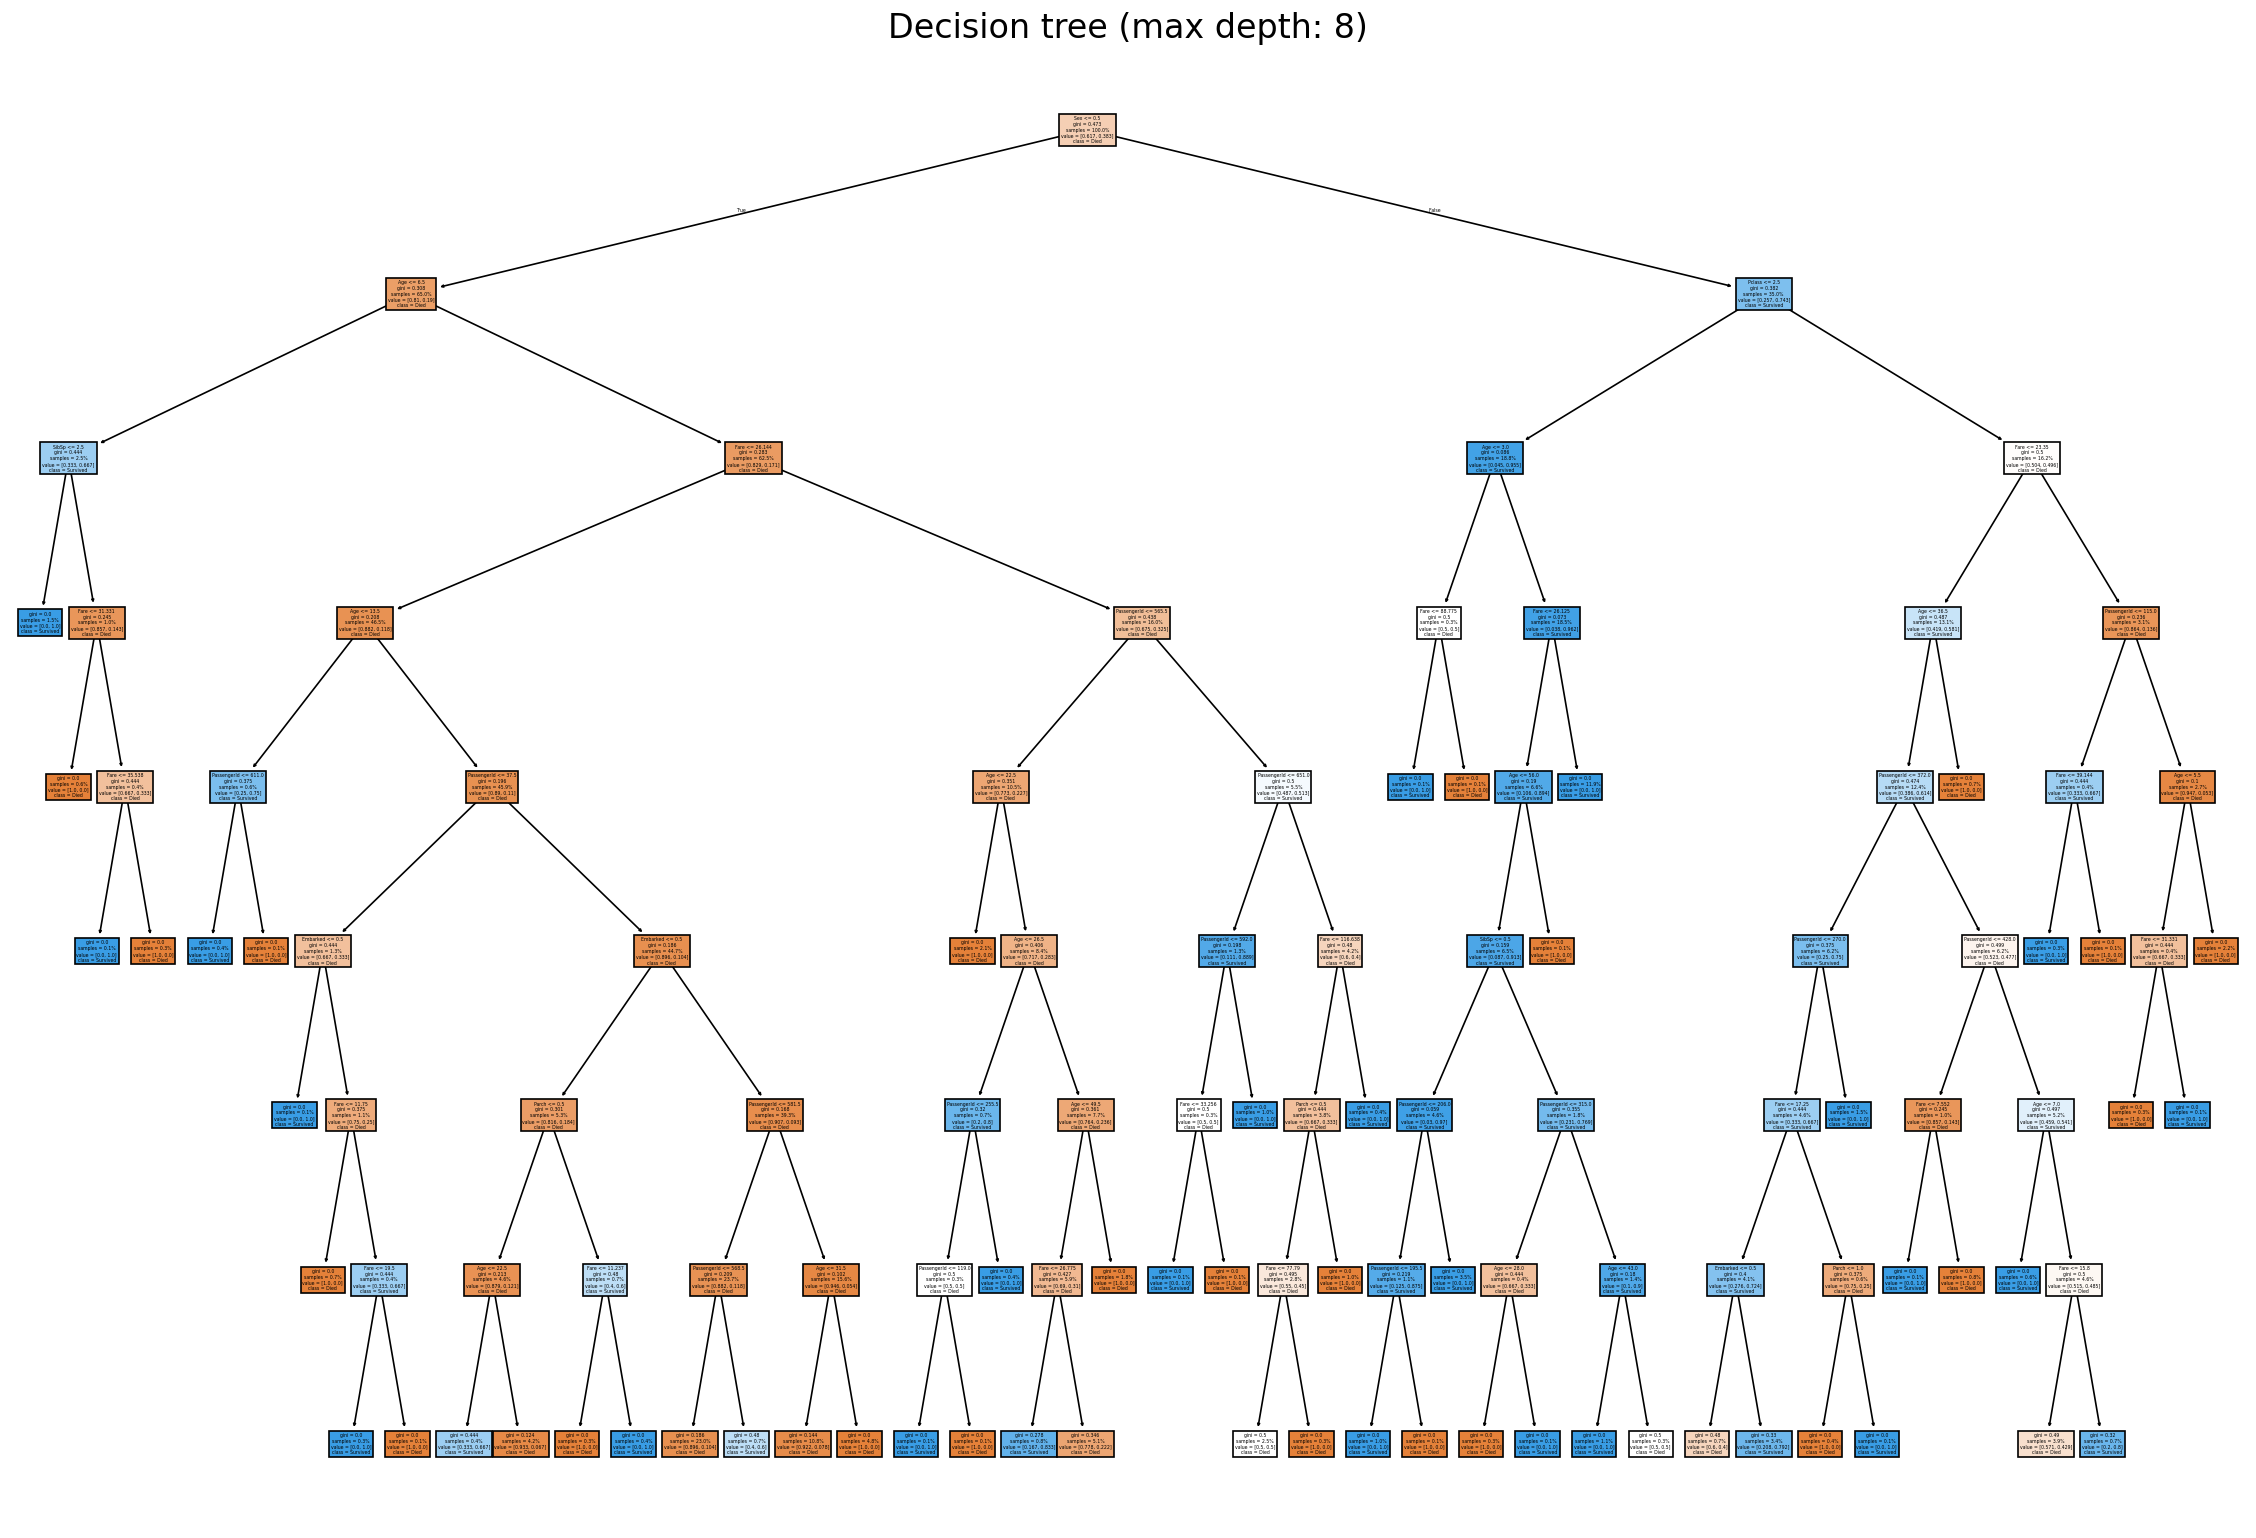

In [13]:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html
# https://mljar.com/blog/visualize-decision-tree/
# https://www.geeksforgeeks.org/changing-colors-for-decision-tree-plot-using-sklearn-plot-tree/

# visualize with diff depths
depths = [3, 5, 8]

for depth in depths:
    plt.figure(figsize=(24, 16), dpi=120)

    dt_clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt_clf.fit(X_train, y_train)

    plot_tree(
        dt_clf,
        feature_names=X.columns,
        class_names=['Died', 'Survived'],
        filled=True,
        proportion=True
    )

    plt.title(f"Decision tree (max depth: {depth})", fontsize=20)
    plt.savefig(f"decision_tree_depth_{depth}.png", dpi=150)
    plt.show()

Higher depth for the tree makes the model more complex. Low depth trees tend to underfit and higher depth trees tend to overfit and increases the model variance.

sensitivity analysis:
        Feature  Importance
2          Sex    0.170950
1       Pclass    0.121229
0  PassengerId    0.015642
3          Age    0.011732
7     Embarked    0.007263
6         Fare    0.001676
4        SibSp    0.000000
5        Parch   -0.004469


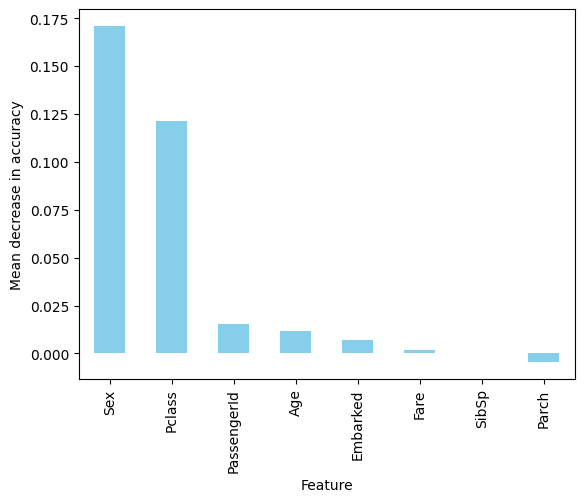

In [10]:
dt_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_clf.fit(X_train, y_train)

perm_importance = permutation_importance(dt_clf, X_test, y_test, n_repeats=10, random_state=42)

importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

print("sensitivity analysis:\n", importances)

importances.plot(kind='bar', x='Feature', y='Importance', legend=False, color='skyblue')
plt.ylabel("Mean decrease in accuracy")
plt.show()

### **Task 2 (30 points)**

In [11]:
# https://www.geeksforgeeks.org/stratified-k-fold-cross-validation/
# https://www.geeksforgeeks.org/random-forest-classifier-using-scikit-learn/
# https://www.geeksforgeeks.org/ml-gradient-boosting/

def evaluate_model(model, X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    accuracies = []
    precisions = []
    f1_scores = []

    # cross-validation
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))

    return np.mean(accuracies), np.mean(precisions), np.mean(f1_scores)

rf_model = RandomForestClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)

# evaluate with 5 10 15 folds
for n_splits in [5, 10, 15]:
    print(n_splits, "folds")
    print(f"\tRandom forest:")
    rf_acc, rf_prec, rf_f1 = evaluate_model(rf_model, X, y, n_splits)
    print(f"\tAccuracy: {rf_acc:.4f},\tPrecision: {rf_prec:.4f},\tF1-score: {rf_f1:.4f}")

    print(f"\n\tGradient boosting:")
    gb_acc, gb_prec, gb_f1 = evaluate_model(gb_model, X, y, n_splits)
    print(f"\tAccuracy: {gb_acc:.4f},\tPrecision: {gb_prec:.4f},\tF1-score: {gb_f1:.4f}")
    print()

5 folds
	Random forest:
	Accuracy: 0.8305,	Precision: 0.8124,	F1-score: 0.7668

	Gradient boosting:
	Accuracy: 0.8227,	Precision: 0.8261,	F1-score: 0.7480

10 folds
	Random forest:
	Accuracy: 0.8260,	Precision: 0.8154,	F1-score: 0.7568

	Gradient boosting:
	Accuracy: 0.8260,	Precision: 0.8324,	F1-score: 0.7523

15 folds
	Random forest:
	Accuracy: 0.8170,	Precision: 0.8090,	F1-score: 0.7456

	Gradient boosting:
	Accuracy: 0.8203,	Precision: 0.8208,	F1-score: 0.7475



Both performances seem pretty consistent, however random forest usually is better in terms of accuracy and gradient boosting is better in terms of precision (and f1 score).

### **Task 3 (40 points)**

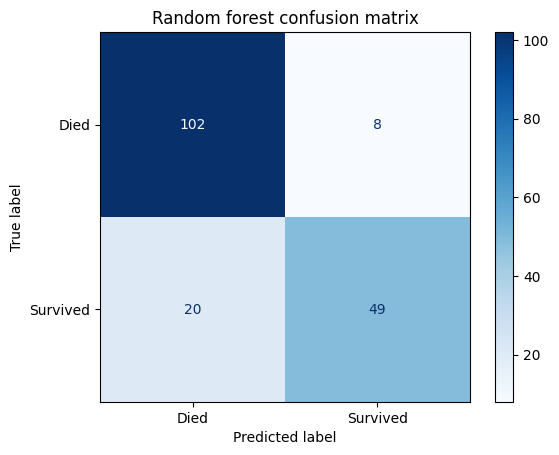

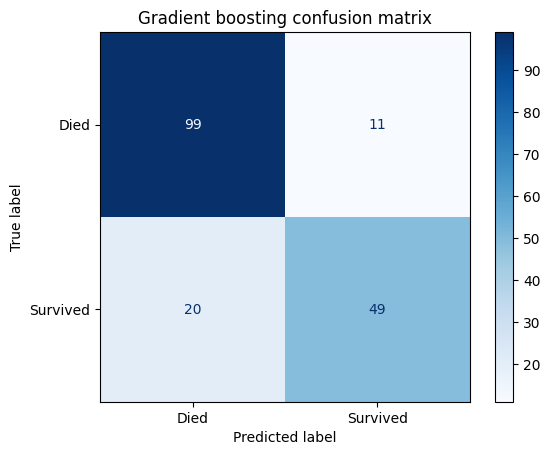

Paired t-test for accuracy:
T-statistic: 0.7249882734930103, P-value: 0.5438076375800656


In [12]:
# https://www.geeksforgeeks.org/how-to-plot-confusion-matrix-with-labels-in-sklearn/
# https://www.geeksforgeeks.org/how-to-conduct-a-paired-samples-t-test-in-python/

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 0
for train_index, test_index in kf.split(X, y):
    if fold == 0:  # Let's take the first fold for analysis
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        break
    fold += 1

# confusion matrix for random forest
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Died", "Survived"])
disp_rf.plot(cmap=plt.cm.Blues)
plt.title('Random forest confusion matrix')
plt.show()

# confusion matrix for gradient boosting
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
cm_gb = confusion_matrix(y_test, y_pred_gb)
disp_gb = ConfusionMatrixDisplay(confusion_matrix=cm_gb, display_labels=["Died", "Survived"])
disp_gb.plot(cmap=plt.cm.Blues)
plt.title('Gradient boosting confusion matrix')
plt.show()

# paired t-test
accuracy_rf = [0.8350, 0.8271, 0.8170]
accuracy_gb = [0.8227, 0.8260, 0.8203]
t_stat, p_value = ttest_rel(accuracy_rf, accuracy_gb)
print(f"Paired t-test for accuracy:\nT-statistic: {t_stat}, P-value: {p_value}")

Since random forest can handle more complexities, it has a lower bias than gradient boosting (gradient boosting can underfit if not enough iterations used). Since gradient boosting doesn't overfit as much, it has a lower variance than random forest.